In [1]:
!pip install librosa

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from IPython.display import Audio
import IPython.display as ipd
import librosa

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Flatten, Dense, Activation, Reshape, Dropout,
                                     BatchNormalization, Conv2D, MaxPool2D)

from sklearn.model_selection import train_test_split

from google.colab import files

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
seed = 17
np.random.seed(seed)

In [5]:
# прописываем пути к папкам
path = '/content/drive/MyDrive/UAI/SMART HOME'
head_path = path + '/Speech Commands/'
test_path = path + '/Reads The Text/'
numpy_path = path + '/numpy/'

In [6]:
# Задаем параметры данных
sample_rate = 22500                       # Частота аудио
feature_dim = 20                          # default - количество mfcc признаков
len_frames = int(.5 * sample_rate)      # длина фрэймов .5
step_mfcc = int(.01 * sample_rate)        # шаг смещения 0.01
channel = 1                         # количество аудио каналов
n_classes = 4                       # количество классов
classes = ['AIR CONDICIONER', 'LIGHT', 'TELEVISION']   # Классы - noise

length = 50000
step = 5000

In [7]:
# Извлекаем лейблы и записываем по названию папок в виде индексов
def createLabels(path=head_path):
    labels = sorted(os.listdir(path))
    labels_indexes = np.arange(0, len(labels))
    labels_indexes_ohe = to_categorical(labels_indexes)   # to_categorica
    
    return labels, labels_indexes, labels_indexes_ohe
    

In [8]:
# Контрол
createLabels()


(['01 air conditioner', '02 light', '03 television', '04 noise'],
 array([0, 1, 2, 3]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=float32))

In [9]:
# Параметризация аудио. length - длина отрезков разбиения, step - шаг смещения
def wav2mfcc(file_path, length=length, step=step):        # length=11025, step=2205
    out_mfcc = []                   # вывод mfcc
    out_audio = []                  # вывод исходного файла
    
    y, sr = librosa.load(file_path)

    while (len(y) >= length):
        section = y[:length]        # начальный отрезок
        section = np.array(section) # в массив
        out_mfcc.append(librosa.feature.mfcc(section, sr))
        out_audio.append(section)
        y = y[step:]   # уменьшаем на шаг

    # в массивы
    out_mfcc = np.array(out_mfcc)
    out_audio = np.array(out_audio)

    return out_mfcc, out_audio


In [10]:
# Функция векторов данных для наборов данных
def saveData2Array(path=head_path, length=length):
    labels , _, _ = createLabels(path)    # лейблы классов
    
    for lb in labels:
        mfcc_vectors = []                  # векторы частот
        wav_files = [path + lb + '/' + wf for wf in os.listdir(path + '/' + lb)]
        for wf in tqdm(wav_files, f'Сохраняем векторы класса: {lb}'):
            mfcc, _ = wav2mfcc(wf, length=length, step=step_mfcc)   # получаем частоты
            if (mfcc.shape[0] != 0):
                mfcc_vectors.extend(mfcc)   # добавляем вектор в список
        np.save(numpy_path + lb + '.npy', mfcc_vectors)   # сохраняем массивы классов


In [11]:
# Функция обучающей и проверочной выборки
def createTrainTest(split_ratio=0.7, random_state=seed, colab=True):
    labels, indexes, _ = createLabels(head_path)   # извлекаем имена и индексы лейблов
    
    # набор векторов для первого класса
    X = np.load(numpy_path + labels[0] + '.npy')
    y = np.zeros(X.shape[0], dtype='int32')

    # объединяем в датасет
    for i, lb in enumerate(labels[1:]):
        if colab:
            X2 = np.load(lb + '.npy')
        else:
            X2 = np.load(numpy_path + lb + '.npy')
        X = np.vstack((X, X2))
        y = np.append(y, np.full(X2.shape[0], fill_value=(i + 1)))   # добавляем в массив y

    # разделяем на обучающую и проверочную выборки
    return train_test_split(X, y, test_size=(1 - split_ratio), random_state=seed, shuffle=True)


Подготовка данных

In [12]:
# Загружаем и сохраняем файлы
saveData2Array(length=len_frames)

Сохраняем векторы класса: 04 noise: 100%|██████████| 50/50 [13:14<00:00, 15.89s/it]


In [13]:
# Создаем выбори
X_train, X_test, y_train, y_test = createTrainTest(colab=False)
print(f' X_train= {X_train.shape}, y_train= {y_train.shape}\
        \n X_test= {X_test.shape}, y_test= {y_test.shape} ')

 X_train= (148378, 20, 22), y_train= (148378,)        
 X_test= (63591, 20, 22), y_test= (63591,) 


In [14]:
# Добавляем канал, со значением=1 в размеры X_train, X_test
X_train = X_train[..., None]
X_test = X_test[..., None]


In [15]:
X_train.shape, X_test.shape

((148378, 20, 22, 1), (63591, 20, 22, 1))

In [16]:
# Лейблы классов в OHE вектора ((0, 1, 0) 
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)


In [17]:
y_train_ohe.shape, y_test_ohe.shape

((148378, 4), (63591, 4))

In [20]:
idx = np.where(y_train==0)
idx[0].shape

(19730,)

Сеть

In [35]:
#def create_model():
model = Sequential([
                    Conv2D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], channel)),
                    Conv2D(64, 3, activation='relu'),
                    MaxPool2D(2),
                    Dropout(0.25),
                    BatchNormalization(),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    Dense(n_classes, activation='softmax')
                  ])


In [36]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train_ohe, batch_size=256, epochs=25, verbose=1, validation_data=(X_test, y_test_ohe))

Epoch 1/25
580/580 [==============================] - 7s 10ms/step - loss: 0.1701 - accuracy: 0.9366 - val_loss: 0.0418 - val_accuracy: 0.9861
Epoch 2/25
580/580 [==============================] - 6s 10ms/step - loss: 0.0366 - accuracy: 0.9872 - val_loss: 0.0202 - val_accuracy: 0.9939
Epoch 3/25
580/580 [==============================] - 6s 10ms/step - loss: 0.0224 - accuracy: 0.9920 - val_loss: 0.0109 - val_accuracy: 0.9958
Epoch 4/25
580/580 [==============================] - 6s 10ms/step - loss: 0.0168 - accuracy: 0.9935 - val_loss: 0.0073 - val_accuracy: 0.9967
Epoch 5/25
580/580 [==============================] - 6s 10ms/step - loss: 0.0146 - accuracy: 0.9940 - val_loss: 0.0071 - val_accuracy: 0.9966
Epoch 6/25
580/580 [==============================] - 6s 11ms/step - loss: 0.0130 - accuracy: 0.9948 - val_loss: 0.0089 - val_accuracy: 0.9958
Epoch 7/25
580/580 [==============================] - 6s 10ms/step - loss: 0.0132 - accuracy: 0.9946 - val_loss: 0.0087 - val_accuracy: 0.9965

In [38]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная точность обучающей выборки: {max(history.history["accuracy"]):.4f} \
\nМинимальная ошибка на обучающей выборе: {min(history.history["loss"]):.4f} \
\nМаксимальная точность проверочной выборки: {max(history.history["val_accuracy"]):.4f} \
\nМинимальная ошибка на проверочной выборе: {min(history.history["val_loss"]):.4f}')

Максимальная точность обучающей выборки: 0.9966 
Минимальная ошибка на обучающей выборе: 0.0062 
Максимальная точность проверочной выборки: 0.9975 
Минимальная ошибка на проверочной выборе: 0.0036


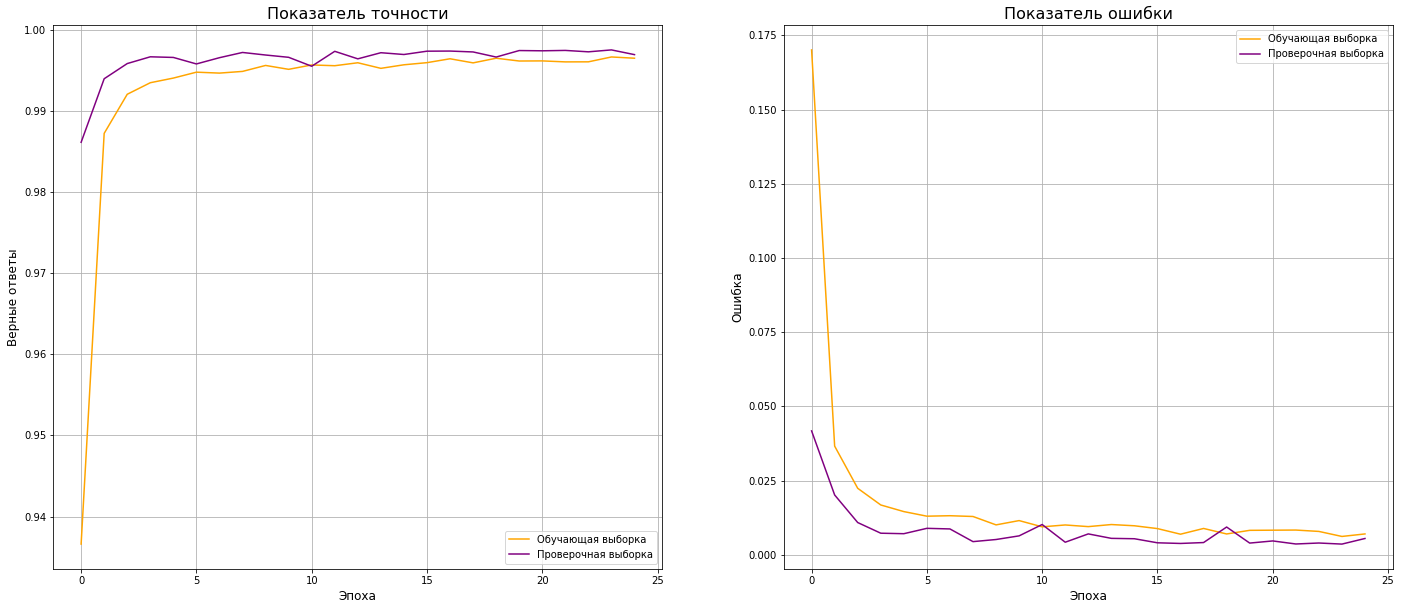

In [39]:
# Графики ошибки и точности на выборках
plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], color='purple', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_loss'], color='purple', label='Проверочная выборка')
plt.title('Показатель ошибки', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.legend()
plt.grid()

plt.show()

Реализация

In [48]:
# Загружаем тестовый wav файл с командой
wav_files = test_path + 'text_with_svet10.wav' # варианты (text_with_televizor6.wav, text_with_cond3.wav)
y, sr = librosa.load(wav_files)
print ('тестовый wav файл:')
ipd.Audio(data=y, rate=sr)

тестовый wav файл:


In [41]:
# Обрабатываем  mfcc массив выбранного файла
mfcc_full, audio_full = wav2mfcc (wav_files, length=len_frames, step=step_mfcc)  
mfcc_full = mfcc_full.reshape(-1, 20, 22, 1)

# Делаем предикт и создаем массив с индексами имеющими максимальное значение 
f_pred = model.predict(mfcc_full)
pred = np.array([np.argmax(i) for i in f_pred])

In [42]:
# Смотрим сетку с результатами
print(f_pred.shape)
print(pred.shape)
print(pred[:1000])

(2930, 4)
(2930,)
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 

In [43]:
# Ищем в сетке элементы искомого класса
idxs = np.where(pred == 1)
idxs = idxs[0]                # Оставляем только первую размерность

print(idxs)

[936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952]


In [44]:
# длинна размерности
len(idxs)

17

In [45]:
# Определяем вероятность правильного распознавания команды из всей сетки(массива)
curr = []

curr_idx = int (idxs[0])
summ, length = 17, 0
for i in range(len(idxs)):
    summ += f_pred[idxs[i]][0]     # сумма вероятности
    length += 1                    # длинна последовательности + 1
    if i == len(idxs) -1:
        if (length >= 2 and summ / length >= 0.95): 
            curr.append([curr_idx, length, summ / length])   # При выполнении условия, в маасив добавляется стартовый индекс найденной команды, длинна последовательности и summ / length
        break        
    if idxs[i+1]-idxs[i] > 1:                                # Если следующий индекс больше текущего на 1, это уже следуующая команда
        if (length >= 8 and summ / length >= 0.95):
            curr.append([curr_idx, length, summ / length]) # При выполнении условия, в маасив добавляется стартовый индекс найденной команды, длинна последовательности и summ / length
        curr_idx = int (idxs[i+1])                         # Изменяем текущий стартовый индекс
        summ, length = 0, 0                                # Обнуляем summ и length
print(curr)

[[936, 17, 1.00000000015901]]


In [46]:
# Из аудиозаписи выбираем команду
np_Audio = []
curr_audio = []    # mfcc отдельной команды
for elem in curr:
    curr_audio = audio_full[elem[0]]
    if (elem[0] != 0):   # Если это не самый первый элемент исходных данных, смещаемс на одну mfcc левее
        curr_audio = np.hstack((audio_full[elem[0] - 1], audio_full[elem[0]][-step_mfcc:]))        
    for j in range(1,elem[1]):
        if (elem[0]+j == len(audio_full)): # При длине elem[0] + j равным длинне mfcc выходим из цикла
            break    
        curr_audio = np.hstack((curr_audio, audio_full[elem[0]+j][-step_mfcc:]))
    curr_audio = np.array(curr_audio)      # В массив numpy
    np_Audio.append([curr_audio, elem[2]]) # Добавляем данные в выходной массив

print (len(curr_audio))

15075


In [50]:
# Проверяем на прослушивании распознанную команду
if (len(np_Audio)==0): # Если длина массива равна 0, то команда не распознана
    print('Команда не распознанана!!!')

for elem in np_Audio:
    print (f'Распознана команда: {classes[1]} c вероятностью {100*elem[1]:.2f} %)')
    ipd.display(ipd.Audio (elem[0], rate = 22050))

Распознана команда: LIGHT c вероятностью 100.00 %)
